The data set provided to you is the data set of a Café Chain for one of its restaurants. 
Do a thorough analysis of the data and come up with the following analysis.

The owner of the restaurant wants you to use this data to come up with a set of recommendations that
can help his Café Chain increase his revenues. He has not been able to launch a loyalty program and is unable 
to provide you with a data set that has customer level information. But, he is able to provide you with a data set
for POS (point of sale data) for one of his chains.

Identify the most popular combos that can be suggested to the restaurant chain after a thorough analysis of the most commonly occurring sets of menu items in the customer orders. The restaurant doesn’t have any combo meals. Can you suggest the best
combo meals? 

!pip install mlxtend

In [60]:
#Loading Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

**Load Dataset**

In [61]:
df=pd.read_excel('Cafe_Data_MRA.xlsx')

**Check Head**

In [62]:
df.head()

,Date,Bill Number,Item Desc,Time,Quantity,Rate,Tax,Discount,Total,Category
0,2010-04-01,G0470115,QUA MINERAL WATER(1000ML),13:15:11,1,50.0,11.88,0.0,61.88,BEVERAGE
1,2010-04-01,G0470115,MONSOON MALABAR (AULAIT),13:15:11,1,100.0,23.75,0.0,123.75,BEVERAGE
2,2010-04-01,G0470116,MASALA CHAI CUTTING,13:17:35,1,40.0,9.50,0.0,49.50,BEVERAGE
3,2010-04-01,G0470117,QUA MINERAL WATER(1000ML),13:19:55,1,50.0,11.88,0.0,61.88,BEVERAGE
4,2010-04-01,G0470283,MOROCCAN MINT TEA,01:20:18,1,45.0,10.69,0.0,55.69,BEVERAGE


**Check Info**

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145830 entries, 0 to 145829
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          145830 non-null  datetime64[ns]
 1   Bill Number   145830 non-null  object        
 2   Item Desc     145830 non-null  object        
 3   Time          145830 non-null  object        
 4   Quantity      145830 non-null  int64         
 5   Rate          145830 non-null  float64       
 6   Tax           145830 non-null  float64       
 7   Discount      145830 non-null  float64       
 8   Total         145830 non-null  float64       
 9   Category      145830 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 11.1+ MB


df.describe().T

**Check Duplicates**

In [64]:
df.duplicated().sum()

680

top_10 = df.groupby('Item Desc').nunique().sort_values('Bill Number ', ascending=False).head(10)
top_10

#grouping category of "FOOD" items

In [68]:
bask = (df[df['Category'] =="FOOD"].groupby(['Bill Number ', 'Item Desc'])['Quantity']
               .sum().unstack().reset_index().fillna(0).set_index('Bill Number '))
bask

Item Desc,2 MUFFINS + BEVERAGE,3COURSE NON-VEG MEAL,3COURSE VEG MEAL,ADD BUTTERED TOAST,ADD CHICKEN,ADD CHICKEN SAUSAGE,ADD COTTAGE CHEESE,ADD FRIES,ADD ICE CREAM,ADD SMOKED CHICKEN,...,VEG FRITTERS,VEG PASTA PESTO,VEG. CLUB WRAP,VEGETABLE PASTA,VERTIGO,WAFFLES + BEVERAGE,WAIST WATCHING OMELETTE,WARM PEPPER & CHICKPEA SALAD,WILD MUSHROOM LINGUINI,YIN N YANG FONDUE
Bill Number,,,,,,,,,,,,,,,,,,,,,
G0470111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G0470114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G0470115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G0470120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G0470121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G0533898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N0027941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N0028811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


df_1=df.groupby(['Bill Number ','Item Desc'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Bill Number ')

df_1

**Encoding the data to avoid negative values if any and make values greater than 1 as 1**

In [69]:
def encode(x): 
    if(x<= 0): 
        return 0
    if(x>= 1): 
        return 1

df_2=df_1.applymap(encode) #mapping the above user defined function

In [70]:
dfbask=bask.applymap(encode)

**Find the support for itemsets using Apriori**

In [86]:
itemsets = apriori(dfbask, min_support = 0.0001, use_colnames = True, low_memory=True)#low support chosen as there are few transactions for more quantities)
itemsets.sort_values('support',ascending=False,inplace=True)
itemsets

,support,itemsets
78,0.150237,(GREAT LAKES SHAKE )
144,0.105299,(POUTINE WITH FRIES )
94,0.101999,(JR.CHL AVALANCHE )
19,0.080347,(B.M.T. PANINI )
129,0.061347,(OREO COOKIE SHAKE )
...,...,...
2715,0.000123,"(MAGGI NDL ARRABIATA , B.M.T. PANINI..."
1275,0.000123,"(CREPES WITH POTATO LAKTES , LAVA LAVA ..."
1274,0.000123,"(CREPES WITH MUSHROOMS , THE FERROR RO..."
2718,0.000123,"(B.M.T. PANINI , MAGGI NDLCREA..."


In [87]:
itemsets['length'] = itemsets['itemsets'].apply(lambda x: len(x))
itemsets

,support,itemsets,length
78,0.150237,(GREAT LAKES SHAKE ),1
144,0.105299,(POUTINE WITH FRIES ),1
94,0.101999,(JR.CHL AVALANCHE ),1
19,0.080347,(B.M.T. PANINI ),1
129,0.061347,(OREO COOKIE SHAKE ),1
...,...,...,...
2715,0.000123,"(MAGGI NDL ARRABIATA , B.M.T. PANINI...",3
1275,0.000123,"(CREPES WITH POTATO LAKTES , LAVA LAVA ...",2
1274,0.000123,"(CREPES WITH MUSHROOMS , THE FERROR RO...",2
2718,0.000123,"(B.M.T. PANINI , MAGGI NDLCREA...",3


In [88]:
itemsets[ (itemsets['length']  == 2) &
                        (itemsets['support'] >= 0.0001) ]

,support,itemsets,length
405,0.008729,"(B.M.T. PANINI , GREAT LAKES S...",2
1517,0.008513,"(GREAT LAKES SHAKE , POUTINE...",2
441,0.008204,"(B.M.T. PANINI , POUTINE WITH ...",2
2247,0.006230,"(PHILLYCREAM CHEESE &CHILLY PAN, POUTINE WITH ...",2
1742,0.006045,"(JR.CHL AVALANCHE , POUTINE WITH ...",2
...,...,...,...
1292,0.000123,"(DUTCH TRUFFLE CAKE SHAKE , MAGGI NDLTHAI...",2
1277,0.000123,"(CRUMBED TOFU CRUSTINI , POUTINE WITH ...",2
1275,0.000123,"(CREPES WITH POTATO LAKTES , LAVA LAVA ...",2
1274,0.000123,"(CREPES WITH MUSHROOMS , THE FERROR RO...",2


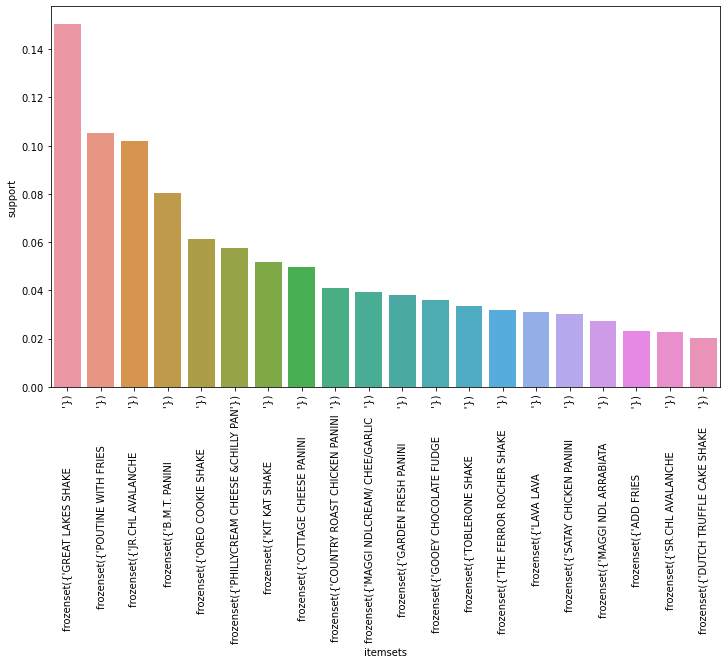

In [89]:
plt.figure(figsize=(12,7))
sns.barplot(itemsets.sort_values('support',ascending=False).iloc[0:20,1],
            itemsets.sort_values('support',ascending=False).iloc[0:20,0])
plt.xticks(rotation=90)
plt.show()

**Check the rules using association_rules**

In [90]:
basket = association_rules(itemsets, metric ="lift") 
basket = basket.sort_values(['lift','confidence'], ascending =[False, False]) 

In [91]:
basket.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7172,"(SAIGON NOODLES , COUNTRY ROAST...",(ADD CHICKEN ),0.000123,0.000956,0.000123,1.000000,1045.870968,0.000123,inf
7173,(ADD CHICKEN ),"(SAIGON NOODLES , COUNTRY ROAST...",0.000956,0.000123,0.000123,0.129032,1045.870968,0.000123,1.148006
3423,"(MUSHROOM , SCRAMBLED EGG...",(CHEDDAR CHEESE ),0.000278,0.001080,0.000185,0.666667,617.561905,0.000185,2.996761
3426,(CHEDDAR CHEESE ),"(MUSHROOM , SCRAMBLED EGG...",0.001080,0.000278,0.000185,0.171429,617.561905,0.000185,1.206562
3424,"(CHEDDAR CHEESE , SCRAMBLED EGG...",(MUSHROOM ),0.000339,0.000987,0.000185,0.545455,552.647727,0.000185,2.197829
3425,(MUSHROOM ),"(CHEDDAR CHEESE , SCRAMBLED EGG...",0.000987,0.000339,0.000185,0.187500,552.647727,0.000185,1.230352
7171,"(ADD CHICKEN , COUNTRY ROAST...",(SAIGON NOODLES ),0.000185,0.001234,0.000123,0.666667,540.366667,0.000123,2.996299
7174,(SAIGON NOODLES ),"(ADD CHICKEN , COUNTRY ROAST...",0.001234,0.000185,0.000123,0.100000,540.366667,0.000123,1.110905
671,(ADD CHICKEN ),(SAIGON NOODLES ),0.000956,0.001234,0.000524,0.548387,444.495161,0.000523,2.211554
670,(SAIGON NOODLES ),(ADD CHICKEN ),0.001234,0.000956,0.000524,0.425000,444.495161,0.000523,1.737468


In [92]:
basket.shape

(8448, 9)

rules = association_rules(itemsets, metric="lift", min_threshold=1)#lift values > 1
rules

In [93]:
basket["antecedent_len"] = basket["antecedents"].apply(lambda x: len(x))
basket

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
7172,"(SAIGON NOODLES , COUNTRY ROAST...",(ADD CHICKEN ),0.000123,0.000956,0.000123,1.000000,1045.870968,0.000123,inf,2
7173,(ADD CHICKEN ),"(SAIGON NOODLES , COUNTRY ROAST...",0.000956,0.000123,0.000123,0.129032,1045.870968,0.000123,1.148006,1
3423,"(MUSHROOM , SCRAMBLED EGG...",(CHEDDAR CHEESE ),0.000278,0.001080,0.000185,0.666667,617.561905,0.000185,2.996761,2
3426,(CHEDDAR CHEESE ),"(MUSHROOM , SCRAMBLED EGG...",0.001080,0.000278,0.000185,0.171429,617.561905,0.000185,1.206562,1
3424,"(CHEDDAR CHEESE , SCRAMBLED EGG...",(MUSHROOM ),0.000339,0.000987,0.000185,0.545455,552.647727,0.000185,2.197829,2
...,...,...,...,...,...,...,...,...,...,...
1699,(GREAT LAKES SHAKE ),"(OREO COOKIE SHAKE , THE FERROR RO...",0.150237,0.002560,0.000308,0.002053,0.801943,-0.000076,0.999492,1
6404,"(OREO COOKIE SHAKE , JR.CHL AVALAN...",(MAGGI NDLCREAM/ CHEE/GARLIC ),0.003917,0.039294,0.000123,0.031496,0.801543,-0.000031,0.991948,2
6405,(MAGGI NDLCREAM/ CHEE/GARLIC ),"(OREO COOKIE SHAKE , JR.CHL AVALAN...",0.039294,0.003917,0.000123,0.003140,0.801543,-0.000031,0.999220,1
1755,(SNICKER BAR SHAKE ),(MEZE PLATTER ),0.018043,0.019215,0.000278,0.015385,0.800642,-0.000069,0.996109,1


In [97]:
criteria1=basket[ (basket['antecedent_len'] >= 2) &
       (basket['confidence'] >= 0.75) &
       (basket['lift'] > 1) ]
criteria1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
7172,"(SAIGON NOODLES , COUNTRY ROAST...",(ADD CHICKEN ),0.000123,0.000956,0.000123,1.000000,1045.870968,0.000123,inf,2
6850,"(NON-VEG CLUB WRAP , SPANISH OMELE...",(THE GREAT INDIAN WRAP ),0.000123,0.006631,0.000123,1.000000,150.800000,0.000123,inf,2
7971,"(VANILLA ICECREAM , SPANISH OMELE...",(CLASSIC BELGIAN WAFFLE ),0.000123,0.008914,0.000123,1.000000,112.186851,0.000122,inf,2
7819,"(BUTTERED TOASTS , OREO COOKIE S...",(KHEEMA GHOTALA ),0.000154,0.009777,0.000123,0.800000,81.822082,0.000122,4.951113,2
5814,"(B.M.T. PANINI , ORANGE ARRABI...",(LEMON INFUSED CHAR GRILLED VEG),0.000154,0.012553,0.000123,0.800000,63.728747,0.000121,4.937234,3
6009,"(ORANGE ARRABIATA , GREAT LAKES S...",(LEMON INFUSED CHAR GRILLED VEG),0.000154,0.012553,0.000123,0.800000,63.728747,0.000121,4.937234,3
6008,"(LEMON INFUSED CHAR GRILLED VEG, GREAT LAKES S...",(ORANGE ARRABIATA ),0.000154,0.015206,0.000123,0.800000,52.611765,0.000121,4.923971,3
4030,"(THE GREAT INDIAN WRAP , SR.CHL AVALAN...",(NON-VEG CLUB WRAP ),0.000154,0.019894,0.000154,1.000000,50.266667,0.000151,inf,2
7336,"(TRADITIONAL ITALIAN CRUSTINI , COUS COUS WRA...",(ADD FRIES ),0.000123,0.023194,0.000123,1.000000,43.114362,0.000121,inf,2
6849,"(THE GREAT INDIAN WRAP , SPANISH OMELE...",(NON-VEG CLUB WRAP ),0.000154,0.019894,0.000123,0.800000,40.213333,0.000120,4.900531,2


In [98]:
criteria2=basket[ (basket['antecedent_len'] == 1) &
       (basket['confidence'] > 0.5) &
       (basket['lift'] > 1) ]
criteria2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
671,(ADD CHICKEN ),(SAIGON NOODLES ),0.000956,0.001234,0.000524,0.548387,444.495161,0.000523,2.211554,1
5292,(CHICKEN HAM ),(SCRAMBLED EGGS ),0.000154,0.008945,0.000154,1.000000,111.800000,0.000153,inf,1
2582,(SPINACH TEMPURA ),(STUFFED MUSHROOM ),0.000370,0.005613,0.000216,0.583333,103.916667,0.000214,2.386528,1
1076,(TOAST BUTTER ),(KHEEMA GHOTALA ),0.000771,0.009777,0.000401,0.520000,53.184353,0.000393,2.062964,1
7454,(MUSHROOM & CORN ),(POUTINE WITH FRIES ),0.000216,0.105299,0.000123,0.571429,5.426730,0.000101,2.087636,1
7506,(RED VELVET CHEESE CAKE ),(POUTINE WITH FRIES ),0.000216,0.105299,0.000123,0.571429,5.426730,0.000101,2.087636,1


In [99]:
criteria1.to_excel(r'C:\Jayamangala\PGPDSBA\MRA project1\condition1.xlsx', index = False)

In [100]:
criteria2.to_excel(r'C:\Jayamangala\PGPDSBA\MRA project1\condition2.xlsx', index = False)